# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 113986942.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102224214.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29862006.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3926324.97it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


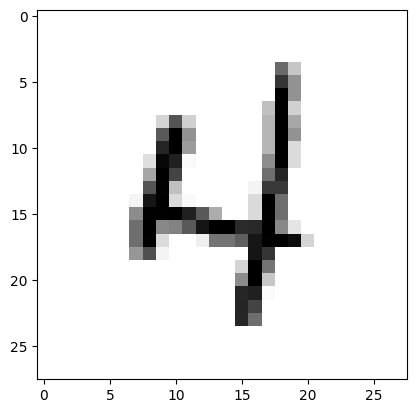

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

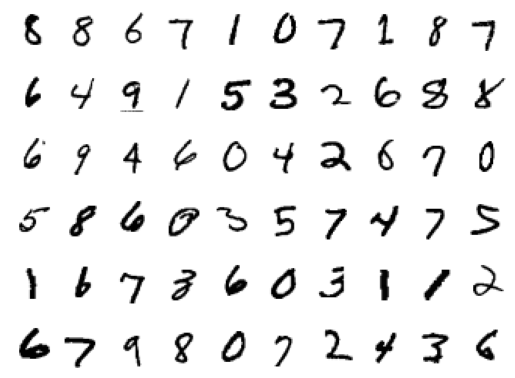

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [30]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 14, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(14)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(14, 12, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(12)
        self.conv4 = nn.Conv2d(12, 12, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(12)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(12, 12, 3)
        self.bn5 = nn.BatchNorm2d(12)
        self.conv6 = nn.Conv2d(12, 10, 3)
        self.bn6 = nn.BatchNorm2d(10)
        self.conv7 = nn.Conv2d(10, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
        x = self.pool2(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))))
        x = F.relu(self.bn6(self.conv6(F.relu(self.bn5(self.conv5(x))))))  # Modified this line
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [31]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 28, 28]              20
            Conv2d-3           [-1, 14, 28, 28]           1,274
       BatchNorm2d-4           [-1, 14, 28, 28]              28
         MaxPool2d-5           [-1, 14, 14, 14]               0
            Conv2d-6           [-1, 12, 14, 14]           1,524
       BatchNorm2d-7           [-1, 12, 14, 14]              24
            Conv2d-8           [-1, 12, 14, 14]           1,308
       BatchNorm2d-9           [-1, 12, 14, 14]              24
        MaxPool2d-10             [-1, 12, 7, 7]               0
           Conv2d-11             [-1, 12, 5, 5]           1,308
      BatchNorm2d-12             [-1, 12, 5, 5]              24
           Conv2d-13             [-1, 10, 3, 3]           1,090
      BatchNorm2d-14             [

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [33]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader )

EPOCH: 0


Loss=0.046744778752326965 Batch_id=468 Accuracy=93.91: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]



Test set: Average loss: 0.0568, Accuracy: 9833/10000 (98.33%)

EPOCH: 1


Loss=0.07109634578227997 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]



Test set: Average loss: 0.0422, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.0319511704146862 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]



Test set: Average loss: 0.0458, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.020357726141810417 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]



Test set: Average loss: 0.0361, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.05078396201133728 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]



Test set: Average loss: 0.0361, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.0106537826359272 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]



Test set: Average loss: 0.0297, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.02199646271765232 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]



Test set: Average loss: 0.0288, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.028937572613358498 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]



Test set: Average loss: 0.0254, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.0006261527887545526 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]



Test set: Average loss: 0.0262, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.02840886265039444 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]



Test set: Average loss: 0.0311, Accuracy: 9892/10000 (98.92%)

EPOCH: 10


Loss=0.0012196085881441832 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]



Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.014871261082589626 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]



Test set: Average loss: 0.0234, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.00043215087498538196 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]



Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.007387816905975342 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]



Test set: Average loss: 0.0293, Accuracy: 9903/10000 (99.03%)

EPOCH: 14


Loss=0.006962685380131006 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]



Test set: Average loss: 0.0276, Accuracy: 9913/10000 (99.13%)



In [34]:
train_losses

[tensor(2.3100, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3071, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3050, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3085, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3100, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2964, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3045, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3078, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2966, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3017, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3057, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2969, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2957, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2993, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2998, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3053, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [35]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

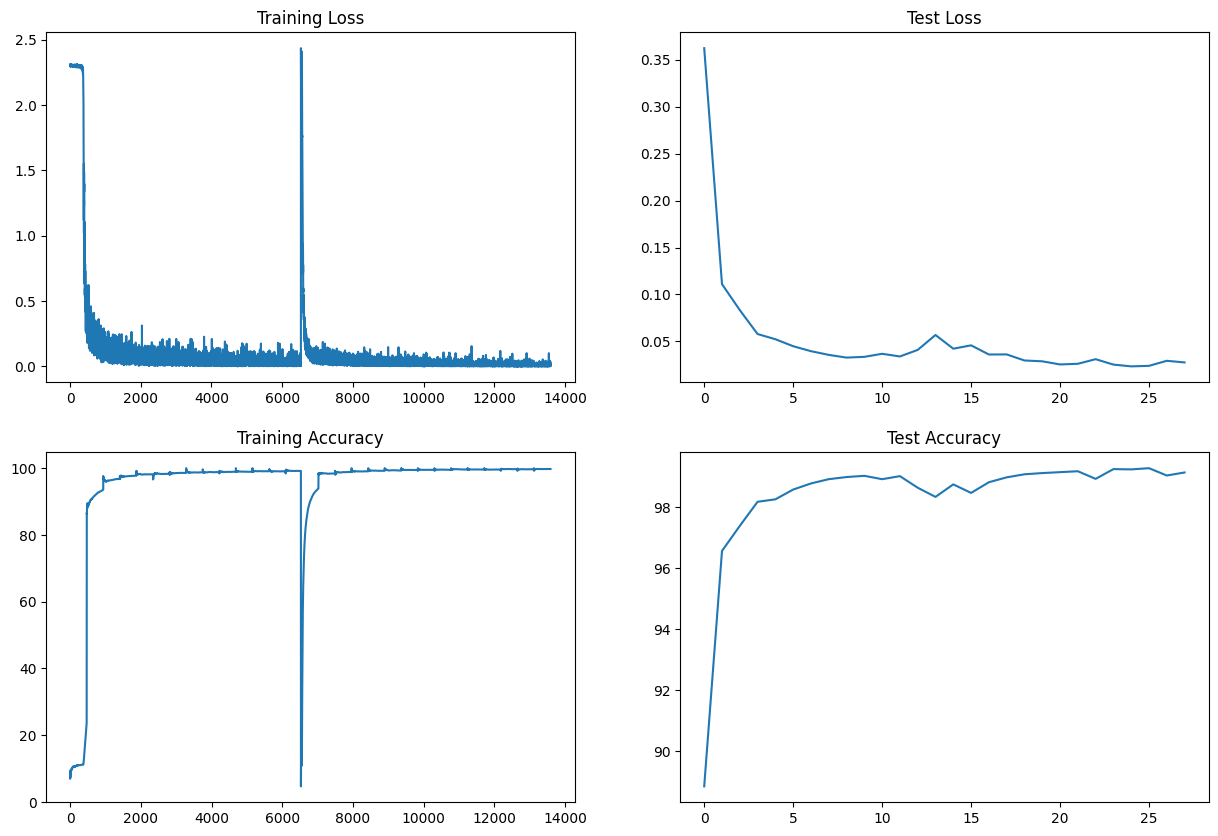

In [36]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")